In [1]:
import sys
file_dir = "/kaggle/input/chuaxong"
sys.path.append(file_dir)


import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from functools import partial 

from data_pipe import (
    iter_wiki_sentences, IterFactory,
    SkipGramPairsIterable, SkipGramDataset, make_collate_fn
)

from embeding_cuda import SGNS, evaluate, LossPlotter
import numpy as np, gc
import time

In [2]:
def precompute_pairs(token_iter, window, rng=None, keep_probs=None, word2id=None, shard_size=5_000_000, out_prefix="pairs"):
    centers, poses = [], []
    shard_idx, count = 0, 0

    for center, pos in SkipGramPairsIterable(token_iter, window, rng, keep_probs, word2id):
        centers.append(center)
        poses.append(pos)
        count += 1

        if count % shard_size == 0:
            np.save(f"{out_prefix}_center_{shard_idx}.npy", np.array(centers, dtype=np.uint32))
            np.save(f"{out_prefix}_pos_{shard_idx}.npy",    np.array(poses, dtype=np.uint32))
            centers, poses = [], []
            shard_idx += 1

    # save phần còn lại
    if centers:
        np.save(f"{out_prefix}_center_{shard_idx}.npy", np.array(centers, dtype=np.uint32))
        np.save(f"{out_prefix}_pos_{shard_idx}.npy",    np.array(poses, dtype=np.uint32))
    print(count, shard_idx)
    return shard_idx

In [3]:
import os
vocab_dir = "/kaggle/input/chuaxong/vocab.pt"
to_save_dir = "/kaggle/working"
os.makedirs(to_save_dir, exist_ok=True)
vocab = torch.load(vocab_dir)
print("loading vocab...")
word2id = vocab["word2id"]
id2word = vocab["id2word"]
counts = vocab["counts"]
count = vocab["count"]

keep_probs = vocab["keep_probs"]
print(len(word2id))

print("loaded vocab...")

#numworker > 0 k goi ham long
train_iter = IterFactory("train")
valid_iter = IterFactory("validation")




loading vocab...
68256
loaded vocab...


In [4]:
shard_idx = precompute_pairs(train_iter, window=6, rng=random.Random(12), keep_probs=keep_probs, word2id=word2id)


README.md: 0.00B [00:00, ?B/s]

wikitext-103-raw-v1/test-00000-of-00001.(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00000-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/train-00001-of-00002(…):   0%|          | 0.00/157M [00:00<?, ?B/s]

wikitext-103-raw-v1/validation-00000-of-(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

54259603 10


env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True
torch.float32
time: 5.993903160095215
step 100: loss=6.7141
time: 6.117411375045776
step 200: loss=4.9847
time: 5.972877025604248
step 300: loss=4.6189
time: 6.124742031097412
step 400: loss=4.2983
time: 6.111990690231323
step 500: loss=4.2076
time: 5.973451137542725
step 600: loss=4.0691
time: 6.120469331741333
step 700: loss=4.0569
time: 6.110217571258545
step 800: loss=3.9222
time: 5.977242708206177
step 900: loss=3.8850
time: 6.110670566558838
step 1000: loss=3.8510
time: 6.11177921295166
step 1100: loss=3.8865
time: 5.983383417129517
step 1200: loss=3.7905
time: 6.1346964836120605
step 1300: loss=3.8071
time: 6.116156339645386
step 1400: loss=3.8292
time: 5.98157262802124
step 1500: loss=3.8438
time: 6.127482175827026
step 1600: loss=3.7993
total_sample : 54259603
Most similar to man:
  hurt        Cos: 1.000
  totally     Cos: 1.000
  pursue      Cos: 1.000
  goes        Cos: 1.000
  call        Cos: 1.000

Most similar to wom

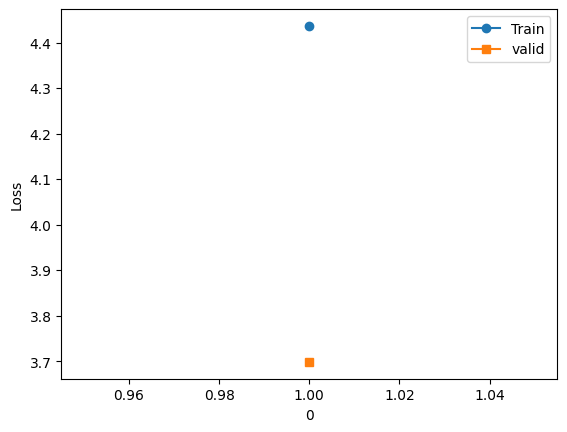

time: 14.37816309928894
step 100: loss=3.8071
time: 6.225759506225586
step 200: loss=3.7437
time: 5.980889081954956
step 300: loss=3.7474
time: 6.113834857940674
step 400: loss=3.7255
time: 6.116259336471558
step 500: loss=3.7073
time: 5.978186368942261
step 600: loss=3.7442
time: 6.12866997718811
step 700: loss=3.7231
time: 6.122074127197266
step 800: loss=3.6844
time: 5.980926513671875
step 900: loss=3.7180
time: 6.125586748123169
step 1000: loss=3.6877
time: 6.118803024291992
step 1100: loss=3.7355
time: 5.976439714431763
step 1200: loss=3.6779
time: 6.116206169128418
step 1300: loss=3.6889
time: 6.122875928878784
step 1400: loss=3.7317
time: 5.978049278259277
step 1500: loss=3.7219
time: 6.126561880111694
step 1600: loss=3.6999
total_sample : 54259603
Most similar to man:
  acknowledged  Cos: 1.000
  portray     Cos: 1.000
  comparing   Cos: 1.000
  wife        Cos: 1.000
  emotion     Cos: 1.000

Most similar to woman:
  reality     Cos: 1.000
  comments    Cos: 1.000
  claiming  

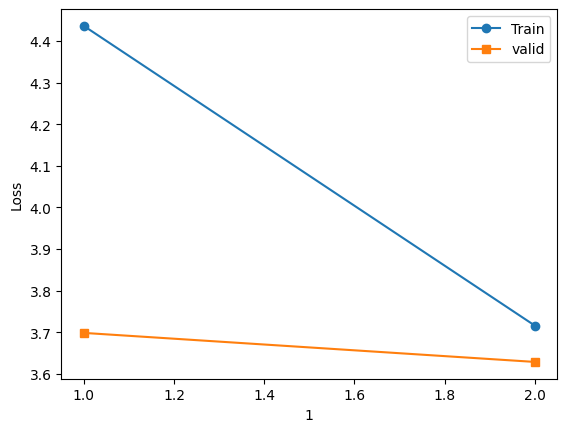

time: 13.570733070373535
step 100: loss=3.7017
time: 6.117211580276489
step 200: loss=3.6491
time: 5.993233919143677
step 300: loss=3.6639
time: 6.133706569671631
step 400: loss=3.6185
time: 6.130346059799194
step 500: loss=3.6344
time: 5.973569869995117
step 600: loss=3.6421
time: 6.1170079708099365
step 700: loss=3.6407
time: 6.109479188919067
step 800: loss=3.5828
time: 5.9765331745147705
step 900: loss=3.6195
time: 6.113146066665649
step 1000: loss=3.6012
time: 6.111053228378296
step 1100: loss=3.6391
time: 5.975949048995972
step 1200: loss=3.6055
time: 6.112784147262573
step 1300: loss=3.6029
time: 6.117259502410889
step 1400: loss=3.6471
time: 5.979577541351318
step 1500: loss=3.6118
time: 6.119117021560669
step 1600: loss=3.6058
total_sample : 54259603
Most similar to man:
  embarrassed  Cos: 0.995
  angrily     Cos: 0.994
  steal       Cos: 0.994
  pretend     Cos: 0.994
  mess        Cos: 0.994

Most similar to woman:
  innocent    Cos: 0.993
  confronts   Cos: 0.992
  declare

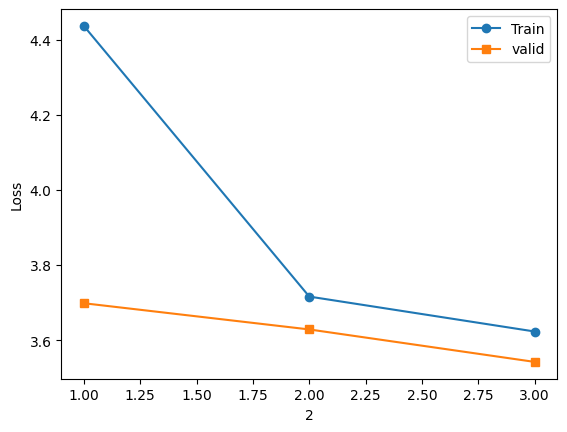

time: 13.28825330734253
step 100: loss=3.5858
time: 6.115161418914795
step 200: loss=3.5592
time: 5.977298736572266
step 300: loss=3.5747
time: 6.112624406814575
step 400: loss=3.5136
time: 6.1120524406433105
step 500: loss=3.5426
time: 5.975568532943726
step 600: loss=3.5473
time: 6.117112159729004
step 700: loss=3.5650
time: 6.117477655410767
step 800: loss=3.4972
time: 5.975009202957153
step 900: loss=3.5197
time: 6.112386226654053
step 1000: loss=3.5063
time: 6.123900651931763
step 1100: loss=3.5445
time: 5.9906182289123535
step 1200: loss=3.5335
time: 6.179859161376953
step 1300: loss=3.5178
time: 6.1382951736450195
step 1400: loss=3.5544
time: 5.995518922805786
step 1500: loss=3.4988
time: 6.1434595584869385
step 1600: loss=3.5183
total_sample : 54259603
Most similar to man:
  prepares    Cos: 0.976
  curse       Cos: 0.972
  nurse       Cos: 0.972
  tearfully   Cos: 0.971
  persuades   Cos: 0.971

Most similar to woman:
  child       Cos: 0.965
  bride       Cos: 0.956
  mother 

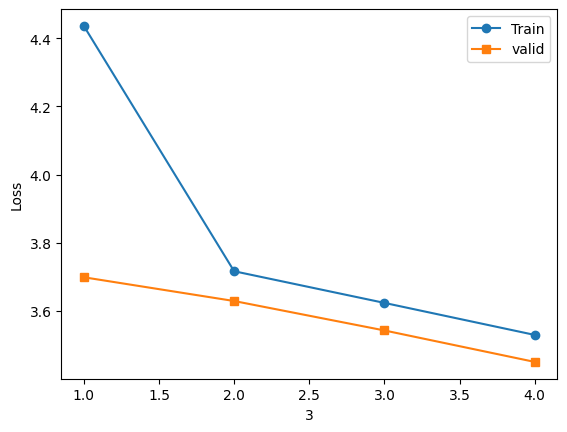

time: 13.439242124557495
step 100: loss=3.4842
time: 6.138409852981567
step 200: loss=3.4791
time: 5.988428592681885
step 300: loss=3.4949
time: 6.136864185333252
step 400: loss=3.4329
time: 6.132400751113892
step 500: loss=3.4526
time: 5.996058702468872
step 600: loss=3.4658
time: 6.131015062332153
step 700: loss=3.5047
time: 6.125135660171509
step 800: loss=3.4241
time: 5.994765758514404
step 900: loss=3.4432
time: 6.117121458053589
step 1000: loss=3.4192
time: 6.119717121124268
step 1100: loss=3.4747
time: 5.97796630859375
step 1200: loss=3.4710
time: 6.127912282943726
step 1300: loss=3.4540
time: 6.119168043136597
step 1400: loss=3.4825
time: 5.9763875007629395
step 1500: loss=3.4046
time: 6.116025924682617
step 1600: loss=3.4554
total_sample : 54259603
Most similar to man:
  curse       Cos: 0.952
  sibling     Cos: 0.943
  swordsman   Cos: 0.942
  ponders     Cos: 0.938
  smithers    Cos: 0.938

Most similar to woman:
  child       Cos: 0.933
  mother      Cos: 0.931
  bride     

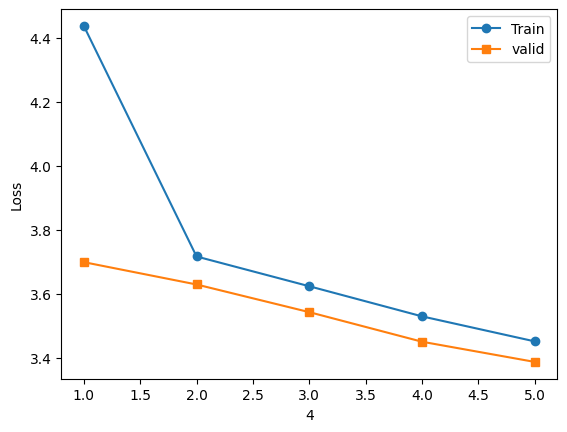

time: 13.31273627281189
step 100: loss=3.4145
time: 6.113980054855347
step 200: loss=3.4142
time: 5.977416038513184
step 300: loss=3.4344
time: 6.115087032318115
step 400: loss=3.3751
time: 6.118335008621216
step 500: loss=3.3778
time: 5.982691287994385
step 600: loss=3.3979
time: 6.137794733047485
step 700: loss=3.4514
time: 6.116445541381836
step 800: loss=3.3663
time: 5.982142448425293
step 900: loss=3.3838
time: 6.127563953399658
step 1000: loss=3.3493
time: 6.134115219116211
step 1100: loss=3.4198
time: 5.981183767318726
step 1200: loss=3.4183
time: 6.129750967025757
step 1300: loss=3.4031
time: 6.1260857582092285
step 1400: loss=3.4250
time: 5.982322692871094
step 1500: loss=3.3275
time: 6.132152557373047
step 1600: loss=3.4050
total_sample : 54259603
Most similar to man:
  swordsman   Cos: 0.913
  thieves     Cos: 0.907
  kenshin     Cos: 0.902
  locket      Cos: 0.902
  sarcastically  Cos: 0.901

Most similar to woman:
  prostitute  Cos: 0.900
  herself     Cos: 0.898
  sibling

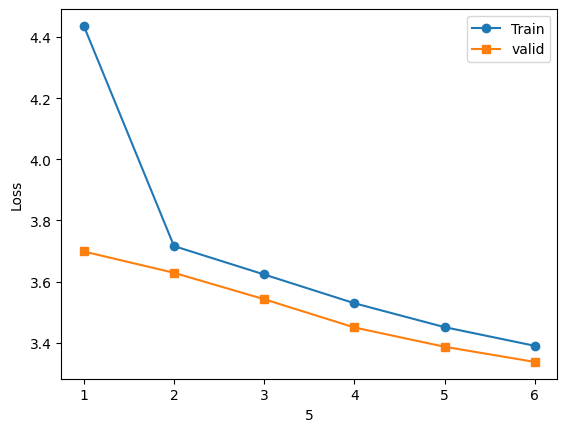

time: 13.929991960525513
step 100: loss=3.3599
time: 6.130484342575073
step 200: loss=3.3623
time: 5.9846789836883545
step 300: loss=3.3901
time: 6.127403974533081
step 400: loss=3.3271
time: 6.137828350067139
step 500: loss=3.3208
time: 5.97924280166626
step 600: loss=3.3461
time: 6.115948915481567
step 700: loss=3.4109
time: 6.125229597091675
step 800: loss=3.3188
time: 5.979296684265137
step 900: loss=3.3357
time: 6.132989168167114
step 1000: loss=3.2989
time: 6.118017196655273
step 1100: loss=3.3735
time: 5.981377840042114
step 1200: loss=3.3762
time: 6.139720678329468
step 1300: loss=3.3646
time: 6.1353631019592285
step 1400: loss=3.3782
time: 5.991345167160034
step 1500: loss=3.2656
time: 6.154787540435791
step 1600: loss=3.3628
total_sample : 54259603
Most similar to man:
  kenshin     Cos: 0.869
  swordsman   Cos: 0.867
  eragon      Cos: 0.865
  reincarnated  Cos: 0.865
  maleficent  Cos: 0.862

Most similar to woman:
  prostitute  Cos: 0.879
  herself     Cos: 0.870
  affecti

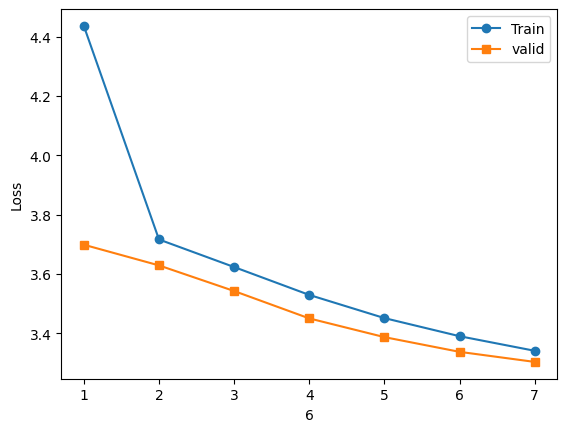

time: 13.815680503845215
step 100: loss=3.3136
time: 6.1117212772369385
step 200: loss=3.3179
time: 5.979884624481201
step 300: loss=3.3477
time: 6.116118907928467
step 400: loss=3.2884
time: 6.125776290893555
step 500: loss=3.2800
time: 5.975287914276123
step 600: loss=3.3015
time: 6.114337682723999
step 700: loss=3.3737
time: 6.1309404373168945
step 800: loss=3.2824
time: 5.973100900650024
step 900: loss=3.2934
time: 6.115045070648193
step 1000: loss=3.2577
time: 6.136868000030518
step 1100: loss=3.3377
time: 5.972540616989136
step 1200: loss=3.3346
time: 6.1151604652404785
step 1300: loss=3.3321
time: 6.118713855743408
step 1400: loss=3.3401
time: 5.97455096244812
step 1500: loss=3.2234
time: 6.113943576812744
step 1600: loss=3.3273
total_sample : 54259603
Most similar to man:
  loner       Cos: 0.828
  eragon      Cos: 0.827
  kenshin     Cos: 0.826
  kitana      Cos: 0.823
  reincarnated  Cos: 0.823

Most similar to woman:
  prostitute  Cos: 0.858
  herself     Cos: 0.850
  orphan

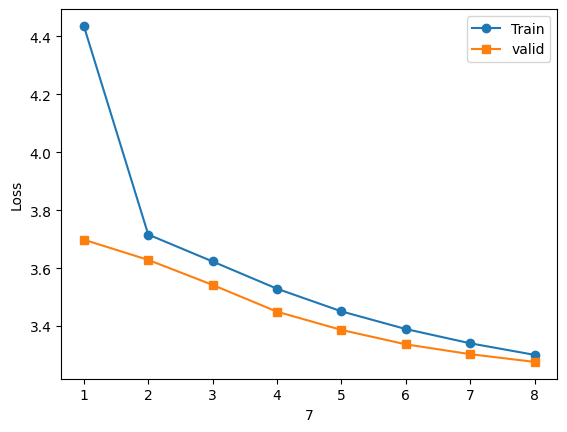

time: 13.853001832962036
step 100: loss=3.2775
time: 6.119501829147339
step 200: loss=3.2792
time: 5.984165668487549
step 300: loss=3.3148
time: 6.113738059997559
step 400: loss=3.2596
time: 6.114563703536987
step 500: loss=3.2459
time: 5.976360082626343
step 600: loss=3.2679
time: 6.124641418457031
step 700: loss=3.3452
time: 6.116502523422241
step 800: loss=3.2528
time: 5.974238634109497
step 900: loss=3.2610
time: 6.11461329460144
step 1000: loss=3.2221
time: 6.113807678222656
step 1100: loss=3.3095
time: 5.974027395248413
step 1200: loss=3.3020
time: 6.114617586135864
step 1300: loss=3.3065
time: 6.11942982673645
step 1400: loss=3.3072
time: 5.975794076919556
step 1500: loss=3.1805
time: 6.112954139709473
step 1600: loss=3.2970
total_sample : 54259603
Most similar to man:
  loner       Cos: 0.800
  kitana      Cos: 0.793
  eragon      Cos: 0.791
  aigis       Cos: 0.788
  kenshin     Cos: 0.788

Most similar to woman:
  prostitute  Cos: 0.838
  herself     Cos: 0.836
  orphan      

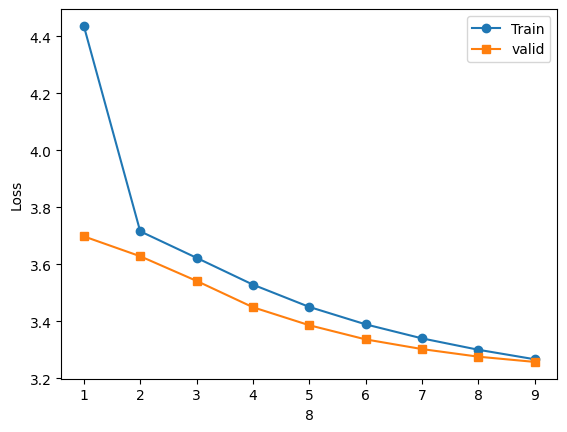

time: 13.767376899719238
step 100: loss=3.2456
time: 6.112640142440796
step 200: loss=3.2483
time: 5.98002028465271
step 300: loss=3.2867
time: 6.10923171043396
step 400: loss=3.2323
time: 6.115553140640259
step 500: loss=3.2163
time: 5.973135948181152
step 600: loss=3.2411
time: 6.11583137512207
step 700: loss=3.3177
time: 6.112174987792969
step 800: loss=3.2264
time: 5.973827362060547
step 900: loss=3.2316
time: 6.118100881576538
step 1000: loss=3.1935
time: 6.136565685272217
step 1100: loss=3.2785
time: 5.98495888710022
step 1200: loss=3.2719
time: 6.122956991195679
step 1300: loss=3.2822
time: 6.115428924560547
step 1400: loss=3.2820
time: 5.9798901081085205
step 1500: loss=3.1521
time: 6.111123561859131
step 1600: loss=3.2663
total_sample : 54259603
Most similar to man:
  loner       Cos: 0.772
  kitana      Cos: 0.762
  yahiko      Cos: 0.759
  aigis       Cos: 0.755
  huntress    Cos: 0.755

Most similar to woman:
  herself     Cos: 0.822
  prostitute  Cos: 0.813
  orphan      C

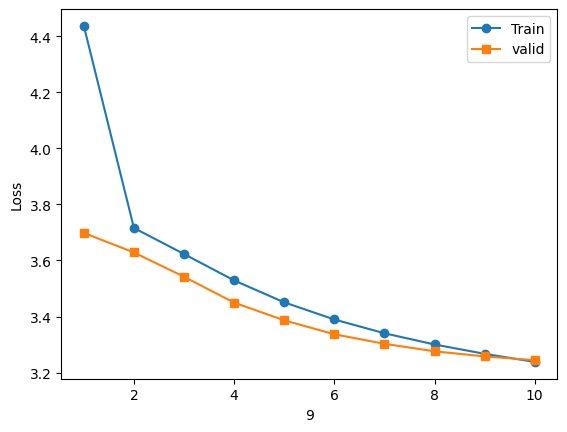

time: 13.815263032913208
step 100: loss=3.2186
time: 6.115886211395264
step 200: loss=3.2218
time: 5.975060701370239
step 300: loss=3.2566
time: 6.110744476318359
step 400: loss=3.2058
time: 6.118502855300903
step 500: loss=3.1894
time: 5.975566148757935
step 600: loss=3.2157
time: 6.131890535354614
step 700: loss=3.2923
time: 6.120666980743408
step 800: loss=3.2018
time: 5.975758075714111
step 900: loss=3.2109
time: 6.1154632568359375
step 1000: loss=3.1684
time: 6.113373279571533
step 1100: loss=3.2555
time: 5.977421045303345
step 1200: loss=3.2444
time: 6.115992784500122
step 1300: loss=3.2533
time: 6.117286682128906
step 1400: loss=3.2545
time: 5.976955413818359
step 1500: loss=3.1227
time: 6.117681980133057
step 1600: loss=3.2417
total_sample : 54259603
Most similar to man:
  loner       Cos: 0.751
  yahiko      Cos: 0.740
  kitana      Cos: 0.735
  cadance     Cos: 0.734
  lawman      Cos: 0.732

Most similar to woman:
  herself     Cos: 0.803
  prostitute  Cos: 0.782
  orphan   

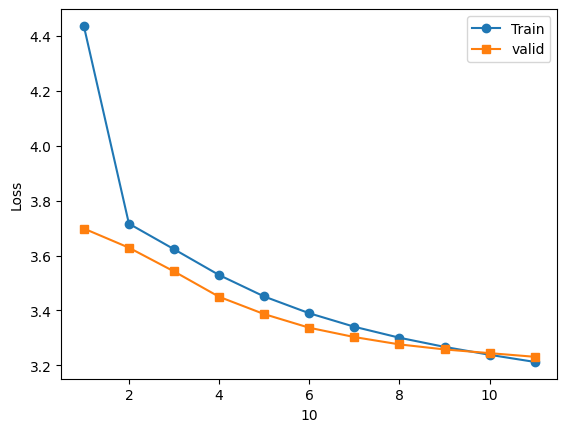

time: 13.78471326828003
step 100: loss=3.1910
time: 6.145244836807251
step 200: loss=3.1923
time: 5.975826263427734
step 300: loss=3.2349
time: 6.112500905990601
step 400: loss=3.1849
time: 6.111536741256714
step 500: loss=3.1669
time: 5.9739155769348145
step 600: loss=3.1882
time: 6.108962535858154
step 700: loss=3.2693
time: 6.113703489303589
step 800: loss=3.1771
time: 5.977007150650024
step 900: loss=3.1852
time: 6.117319107055664
step 1000: loss=3.1398
time: 6.121116399765015
step 1100: loss=3.2355
time: 5.973716497421265
step 1200: loss=3.2212
time: 6.121922969818115
step 1300: loss=3.2321
time: 6.113834857940674
step 1400: loss=3.2357
time: 5.9765894412994385
step 1500: loss=3.0971
time: 6.116264820098877
step 1600: loss=3.2156
total_sample : 54259603
Most similar to man:
  loner       Cos: 0.723
  yahiko      Cos: 0.718
  lawman      Cos: 0.715
  cadance     Cos: 0.712
  snuck       Cos: 0.709

Most similar to woman:
  herself     Cos: 0.782
  sabrina     Cos: 0.754
  prostitut

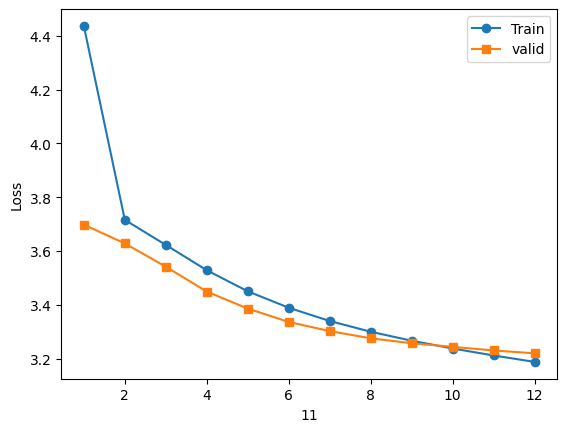

In [7]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

valid_pairs_iterable = SkipGramPairsIterable(valid_iter, window=5, rng=random.Random(111), keep_probs=keep_probs, word2id=word2id)
valid_dataset = SkipGramDataset(valid_pairs_iterable)
collate_fn = partial(make_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32768, collate_fn=collate_fn,
                          num_workers=1, pin_memory=True, persistent_workers=True,
                          prefetch_factor=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SGNS(len(id2word), neg_k=15, counts= counts, dim=256).to(device)
print(model.embed_in.weight.dtype)
opt = torch.optim.SparseAdam(model.parameters(), lr=1e-3)


lossplot = LossPlotter()

start = time.time()
base_seed=111
BATCH_SIZE = 32768
scaler = torch.amp.GradScaler("cuda")


for epoch in range(12):
    model.train()
    generator = torch.Generator(device=device).manual_seed(epoch+base_seed)

    train_loss = 0.0
    total_sample = 0
    step = 0
    for i in range(shard_idx+1):
        center_cpu = torch.from_numpy(np.load(f"/kaggle/working/pairs_center_{i}.npy", mmap_mode="r"))
        pos_cpu   = torch.from_numpy(np.load(f"/kaggle/working/pairs_pos_{i}.npy", mmap_mode="r"))
        for j in range(0, len(center_cpu), BATCH_SIZE):
            step += 1
            center = center_cpu[j:j+BATCH_SIZE].pin_memory().to(device, dtype=torch.long, non_blocking=True)
            pos = pos_cpu[j:j+BATCH_SIZE].pin_memory().to(device, dtype=torch.long, non_blocking=True)
            B = center.shape[0]
            
            opt.zero_grad(set_to_none=True)
            
            if scaler is not None:
                with torch.amp.autocast("cuda"):
                    loss = model(center, pos, generator=generator, device=device) 
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss = model(c, p, generator=generator, device=device)
                loss.backward()
                opt.step()
                
            train_loss += loss.item() * B
            total_sample += B

            if step % 100 == 0:
                end = time.time()
                elapsed = end - start
                start = end
                print(f"time: {elapsed}")
                print(f"step {step}: loss={loss.item():.4f}")
                    
        del center_cpu, pos_cpu
        gc.collect()
        
    print(f"total_sample : {total_sample}")
    train_loss = train_loss / total_sample

    model.eval()
    valid_loss = 0.0
    total_sample = 0
    for batch in valid_loader:
        center = batch["center"].to("cuda", dtype=torch.long, non_blocking=True)
        pos = batch["pos"].to("cuda", dtype=torch.long, non_blocking=True)
        B = center.shape[0]

        loss = model(center, pos, generator)
        valid_loss += loss.item() * B
        total_sample += B   
    valid_loss = valid_loss / total_sample
    evaluate(model, word2id, id2word, wid=["man", "woman", "king", "queen", "happy", "shit", "good", "bad", "nice", "time"])
    lossplot.update(epoch, train_loss, valid_loss)

    if epoch >= 5:
        bundle = {"word2id" : word2id,
                  "id2word" : id2word,
                  "w_in" : model.embed_in.weight.detach().cpu().float(),
                  "w_out" : model.embed_out.weight.detach().cpu().float()
                  }    
        save_emb_path = os.path.join(to_save_dir, f"epoch{epoch}")
        torch.save(bundle, save_emb_path)